In [175]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

In [176]:
mnist = torchvision.datasets.MNIST('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=16, shuffle=True)

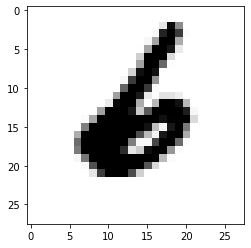

In [177]:
images, labels = next(iter(dataloader))

plt.imshow(images[0, 0], cmap='Greys')
plt.show()

In [186]:
class GatedConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask_center = False):
        super(GatedConvolution, self).__init__()

        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2, kernel_size // 2 + int(mask_center == False):] = 0
        mask[kernel_size // 2 + 1:] = 0
        self.register_buffer('mask', mask)
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # set the focus point of the convolution to 0
        self.conv.weight.data *= self.mask
        
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x

class PixelCNN(nn.Module):
    def __init__(self, hidden_size=32, hidden_count=15):
        super(PixelCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            GatedConvolution(1, hidden_size, kernel_size=7, mask_center=True),
            *([GatedConvolution(hidden_size, hidden_size, kernel_size=3)]*hidden_count),
            nn.Conv2d(hidden_size, 256, kernel_size=1, bias=False),
        )
        
    def forward(self, x):
        return self.cnn(x).permute(0, 2, 3, 1)

In [187]:
pixelCNN = PixelCNN(64, 7)
pixelCNN.cuda()

PixelCNN(
  (cnn): Sequential(
    (0): GatedConvolution(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): GatedConvolution(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): GatedConvolution(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): GatedConvolution(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): GatedConv

In [ ]:
epochs = 20
print_every = 500

optimizer = optim.Adam(pixelCNN.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 10]).cuda())

for e in range(1, epochs+1):
    total_loss = 0
    pixelCNN.train()
    for batch, (images, labels) in enumerate(dataloader):
        images = images.cuda()
        target = (images * 255).long().view(-1)
        
        pred = pixelCNN(images)
        pred = pred.contiguous().view(-1, 256)
        
        loss = criterion(pred, target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)}")

Epoch 1 (500/3750) - loss 3.518610071897507
Epoch 1 (1000/3750) - loss 2.297934065282345
Epoch 1 (1500/3750) - loss 1.823931870063146
Epoch 1 (2000/3750) - loss 1.5791080386936664
Epoch 1 (2500/3750) - loss 1.4304657124996185
Epoch 1 (3000/3750) - loss 1.329449253420035
Epoch 1 (3500/3750) - loss 1.2558438196693147
Epoch 1 (3750/3750) - loss 1.2260171822865804
Epoch 2 (500/3750) - loss 0.8034354287385941
Epoch 2 (1000/3750) - loss 0.8015150263309478
Epoch 2 (1500/3750) - loss 0.800840026696523
Epoch 2 (2000/3750) - loss 0.7999077412188054
Epoch 2 (2500/3750) - loss 0.7985126483917236
Epoch 2 (3000/3750) - loss 0.7971583453615506
Epoch 2 (3500/3750) - loss 0.795571159686361
Epoch 2 (3750/3750) - loss 0.7950209711869558
Epoch 3 (500/3750) - loss 0.7835225384235383
Epoch 3 (1000/3750) - loss 0.7820484685301781
Epoch 3 (1500/3750) - loss 0.7809921594063441
Epoch 3 (2000/3750) - loss 0.7815805571079254
Epoch 3 (2500/3750) - loss 0.7806578437805176
Epoch 3 (3000/3750) - loss 0.77948404999574

In [ ]:
# check generation
images, labels = next(iter(dataloader))
pixelCNN.eval()
with torch.no_grad():
    pred = pixelCNN(images.cuda())
    pred = pred.softmax(-1).argmax(-1)

plt.imshow(pred[0].cpu(), cmap='Greys')
plt.show()

In [ ]:
# sample
num_samples = 1
sample = torch.zeros(num_samples, 1, 28, 28).cuda()
temperature = 0.7

pixelCNN.eval()
with torch.no_grad():
    for i in range(28):
        for j in range(28):
            pred = pixelCNN(sample)
            pred = (pred[:, i, j]/temperature).softmax(dim=-1)
            
            pixel = torch.multinomial(pred, 1).float() / 255.
            sample[:, :, i, j] = pixel
            
plt.imshow(sample[0,0].cpu(), cmap='Greys')
plt.show()